In [56]:
import numpy as np
import pandas as pd

import joblib
import sqlite3
import operator as op

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from collections import defaultdict
from tqdm.notebook import tqdm

from utils.get_or_create_combined_database import get_or_create_combined_database
from utils.create_compound_key_and_index import create_compound_key_and_index

from concurrent.futures import ProcessPoolExecutor

from constants import DB_columns, GAME_AREA_WIDTH

from matplotlib import pyplot as plt

import os
from dotenv import load_dotenv
load_dotenv(verbose=True, override=True)

RECREATE_CLEANED_DATA = False

zoom_range = ((75, 14350), (75, 14350))
normalized_zoom_range = ((0, 1), (0, 1))

In [57]:
database_folder = os.getenv("DATABASE_FOLDER")

database_file = get_or_create_combined_database(database_folder)

conn = sqlite3.connect(database_file)
cursor = conn.cursor()

tlol_db_table_name = "champs"

page_size = 5

rows = cursor.execute(
    f"SELECT * FROM {tlol_db_table_name} LIMIT {page_size}").fetchall()
conn.close()
print(f"Loaded {len(rows)} rows from the database as a test")

rows[0:5]

Found 2 database files in the folder specified by DATABASE_FOLDER
Found combined database /u/23/tarpill1/unix/Documents/combined2.db
Loaded 5 rows from the database as a test


[('Mordekaiser',
  604.0,
  612.0,
  1.005585,
  645.0,
  100,
  2841236401,
  '2841236401_100_Mordekaiser'),
 ('Viego',
  664.0,
  286.0,
  1.005585,
  630.0,
  100,
  2841236401,
  '2841236401_100_Viego'),
 ('Riven',
  364.0,
  136.0,
  1.005585,
  645.0,
  100,
  2841236401,
  '2841236401_100_Riven'),
 ('Ezreal',
  132.0,
  402.0,
  1.005585,
  600.0,
  100,
  2841236401,
  '2841236401_100_Ezreal'),
 ('Leblanc',
  298.0,
  676.0,
  1.005585,
  598.0,
  100,
  2841236401,
  '2841236401_100_Leblanc')]

In [58]:
cleaned_table_name = f"{tlol_db_table_name}_cleaned"


# Create a new table for cleaned up data
if RECREATE_CLEANED_DATA:
    conn = sqlite3.connect(database_file)
    cursor = conn.cursor()

    # Drop previous table
    cursor.execute(f"DROP TABLE IF EXISTS {cleaned_table_name}")

    conn.commit()

    cursor.execute(
        f"CREATE TABLE {cleaned_table_name} AS SELECT * FROM {tlol_db_table_name} WHERE 1=0")

    # Add normalized columns

    cursor.execute(
        f"ALTER TABLE {cleaned_table_name} ADD COLUMN {DB_columns.NORMALIZED_POS_X.value} FLOAT GENERATED ALWAYS AS ({DB_columns.POS_X.value} / {GAME_AREA_WIDTH}) STORED")
    cursor.execute(
        f"ALTER TABLE {cleaned_table_name} ADD COLUMN {DB_columns.NORMALIZED_POS_Z.value} FLOAT GENERATED ALWAYS AS ({DB_columns.POS_Z.value} / {GAME_AREA_WIDTH}) STORED")
    conn.commit()
    conn.close()

In [59]:
# Add data to the new table from original table according to a filter

# Conditions:
# Only rows with a name that is not empty
not_empty_name = f"{DB_columns.NAME.value} IS NOT ''"

# Only rows with a name that is not "Turret"

# Only rows with timestamp greater than 5
timestamp_greater_than_5 = f"{DB_columns.TIME.value} > 5"

# Only rows with pos_x and pos_y greater between [0, GAME_AREA_WIDTH]
pos_x_greater_than_0 = f"{DB_columns.POS_X.value} > 0"
pos_x_less_than_max = f"{DB_columns.POS_X.value} < {GAME_AREA_WIDTH}"
pos_z_greater_than_0 = f"{DB_columns.POS_Z.value} > 0"
pos_z_less_than_max = f"{DB_columns.POS_Z.value} < {GAME_AREA_WIDTH}"
position_between_0_and_max = " AND ".join(
    [pos_x_greater_than_0, pos_x_less_than_max, pos_z_greater_than_0, pos_z_less_than_max])

# Combine all above filters

filter_conditions = " AND ".join(
    [not_empty_name, timestamp_greater_than_5, position_between_0_and_max])

In [60]:
# Add cleaned indices to new table
if RECREATE_CLEANED_DATA:
    conn = sqlite3.connect(database_file)
    cursor = conn.cursor()

    cursor.execute(
        f"INSERT INTO {cleaned_table_name} SELECT * FROM {tlol_db_table_name} WHERE {filter_conditions}")

    conn.commit()
    conn.close()

In [61]:
# Check values from the new table

conn = sqlite3.connect(database_file)
cursor = conn.cursor()

page_size = 5

rows = cursor.execute(
    f"SELECT * FROM {cleaned_table_name} LIMIT {page_size}").fetchall()

conn.close()

rows

[('Mordekaiser',
  604.0,
  612.0,
  5.5419455,
  645.0,
  100,
  2841236401,
  '2841236401_100_Mordekaiser',
  0.040266666666666666,
  0.0408),
 ('Viego',
  786.0,
  436.0,
  5.5419455,
  630.0,
  100,
  2841236401,
  '2841236401_100_Viego',
  0.0524,
  0.029066666666666668),
 ('Riven',
  364.0,
  136.0,
  5.5419455,
  745.0,
  100,
  2841236401,
  '2841236401_100_Riven',
  0.024266666666666666,
  0.009066666666666667),
 ('Ezreal',
  132.0,
  402.0,
  5.5419455,
  600.0,
  100,
  2841236401,
  '2841236401_100_Ezreal',
  0.0088,
  0.0268),
 ('Leblanc',
  298.0,
  676.0,
  5.5419455,
  598.0,
  100,
  2841236401,
  '2841236401_100_Leblanc',
  0.019866666666666668,
  0.045066666666666665)]

In [62]:
# Create indices for given columns

conn = sqlite3.connect(database_file)
cursor = conn.cursor()


def create_index(cursor, table_name, column_name):
    if RECREATE_CLEANED_DATA:
        cursor.execute(
            f"DROP INDEX IF EXISTS {table_name}_{column_name}_index")
        cursor.execute(
            f"CREATE INDEX IF NOT EXISTS {table_name}_{column_name}_index ON {table_name}({column_name})")


columns_to_be_indexed = [DB_columns.NAME.value]

for column in columns_to_be_indexed:
    create_index(cursor, cleaned_table_name, column)
conn.commit()
conn.close()

# List out indices

conn = sqlite3.connect(database_file)
cursor = conn.cursor()


print(create_compound_key_and_index(database_file, cleaned_table_name, [
    DB_columns.GAME_ID.value, DB_columns.TEAM.value, DB_columns.NAME.value]))

indices = cursor.execute(
    f"PRAGMA index_list({cleaned_table_name})").fetchall()

table_info = cursor.execute(
    f"PRAGMA table_info({cleaned_table_name})").fetchall()

conn.close()

print(indices)
print(table_info)

Compound key and index created for table 'champs_cleaned' with key expression: game_id || '_' || team || '_' || name
[(0, 'champs_cleaned_name_index', 0, 'c', 0), (1, 'champs_cleaned_compound_key_idx', 0, 'c', 0)]
[(0, 'name', 'TEXT', 0, None, 0), (1, 'pos_x', 'REAL', 0, None, 0), (2, 'pos_z', 'REAL', 0, None, 0), (3, 'time', 'REAL', 0, None, 0), (4, 'hp', 'REAL', 0, None, 0), (5, 'team', 'INT', 0, None, 0), (6, 'game_id', 'INT', 0, None, 0), (7, 'compound_key', 'TEXT', 0, None, 0)]


In [63]:
def get_counts(cursor, table_name, filter):
    cursor.execute(
        f"SELECT COUNT(DISTINCT {DB_columns.COMPOUND_KEY.value}) FROM {table_name} WHERE {filter}")
    unique_keys = cursor.fetchone()[0]
    cursor.execute(
        f"SELECT COUNT(*), {DB_columns.COMPOUND_KEY.value} FROM {table_name} WHERE {filter} GROUP BY {DB_columns.COMPOUND_KEY.value} ORDER BY {DB_columns.COMPOUND_KEY.value}")
    counts = cursor.fetchall()
    return unique_keys, counts


conn = sqlite3.connect(database_file)
cursor = conn.cursor()

filter = "1=1"  # f"{DB_columns.NAME.value} = 'Ezreal'"

unique_keys, counts = get_counts(cursor, cleaned_table_name, filter)
conn.close()

offsets = []
cumulative_sum = 0

for count in counts:
    offsets.append(cumulative_sum)
    cumulative_sum += count[0]
offsets.append(cumulative_sum)

unique_keys, cumulative_sum

(100580, 65821670)

In [64]:
# Define features to fetch from the database

data_features = [DB_columns.NORMALIZED_POS_X.value,
                 DB_columns.NORMALIZED_POS_Z.value]

In [65]:
def get_data_by_compound_key(cursor, table_name, offset, limit, filter):
    return cursor.execute(
        f"SELECT {','.join(data_features)} FROM {table_name} WHERE {filter} ORDER BY {DB_columns.COMPOUND_KEY.value} LIMIT {limit} OFFSET {offset}"
    ).fetchall()


def get_data(cursor, table_name, offset, limit, counts, offsets, total, filter):
    all_rows = get_data_by_compound_key(
        cursor, table_name, offset, limit, filter)

    rows_per_key = defaultdict(list)

    for i in tqdm(range(total)):
        result_offset = offsets[i] - offset
        result_count = counts[i][0]
        key_slice = all_rows[result_offset:result_offset + result_count]
        if len(key_slice) > 0:
            rows_per_key[counts[i][1]].extend(key_slice)

    return rows_per_key


conn = sqlite3.connect(database_file)
cursor = conn.cursor()

# Adjust this based on the actual number of compound keys
total = 1  # int(unique_keys / 20)
total_count = offsets[total]

batches = min(total, 10)  # Update the number of batches as required

batch_key_counts = [int(total / batches)] * batches
batch_key_counts[-1] += total % batches

batch_offsets = []
batch_counts = []
batch_cumulative_sum = []
cumulative_sum = 0

for count in batch_key_counts:
    batch_offsets.append(offsets[cumulative_sum:count + cumulative_sum])
    batch_counts.append(counts[cumulative_sum:count + cumulative_sum])
    batch_cumulative_sum.append(cumulative_sum)
    cumulative_sum += count

rows_per_key = defaultdict(list)
with tqdm(total=total_count) as pbar:  # Adjust the progress bar total if needed
    for i in range(batches):
        offset = offsets[batch_cumulative_sum[i]]
        limit = offsets[batch_cumulative_sum[i] + batch_key_counts[i]] - offset
        keys_per_batch = batch_key_counts[i]

        offsets_of_batch = batch_offsets[i]
        counts_of_batch = batch_counts[i]

        batch_rows_per_key = get_data(
            cursor, cleaned_table_name, offset, limit, counts_of_batch, offsets_of_batch, keys_per_batch, filter)
        for key, rows in batch_rows_per_key.items():
            pbar.update(len(rows))
            rows_per_key[key].extend(rows)

conn.close()

print(f"Got {len(rows_per_key)} keys")

  0%|          | 0/656 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Got 1 keys


In [66]:
data = np.array(list(rows_per_key.values()), dtype=object)

In [67]:
def create_sequences(rows, H, T):
    num_sequences = len(rows) - H - T + 1
    if num_sequences <= 0:
        return np.array([]), np.array([])

    X = np.lib.stride_tricks.sliding_window_view(
        rows, window_shape=(H, rows.shape[1]))[:-T]
    y = rows[H+T-1:num_sequences+H+T-1]

    return X, y


def create_sequences_from_database_rows(data, H, T):
    batch_size = 1000
    X_list, y_list = [], []
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        for rows in batch:
            if len(rows) < H + T:
                continue
            # # Ensure all sequences are from the same points in time
            # equilength_rows = np.array(rows)[max_H-H:-(max_T-T+1)]
            _X, _y = create_sequences(np.array(rows), H, T)
            if _X.size > 0 and _y.size > 0:
                X_list.append(_X)
                y_list.append(_y)

    if X_list and y_list:
        X = np.concatenate(X_list, axis=0)
        y = np.concatenate(y_list, axis=0)
    else:
        X, y = np.array([]), np.array([])

    return X, y


H = 3
T = 1

X, y = create_sequences_from_database_rows(data, H, T)


X.shape, y.shape

((653, 1, 3, 2), (653, 2))

Number of rows: 1
Average number of rows in a group: 656.0
Number of sequences: 653


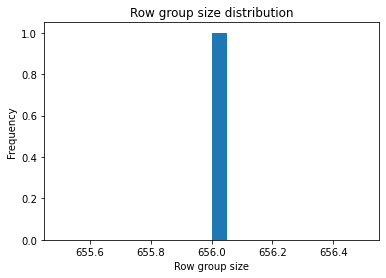

In [68]:
# Statistics about the data

# How many row groups are there?
print(f"Number of rows: {data.shape[0]}")

# How many rows in a group on average?
row_counts = [len(row) for row in data]
print(f"Average number of rows in a group: {np.mean(row_counts)}")

# Statistics about the sequences

# How many sequences are there?
print(f"Number of sequences: {X.shape[0]}")

# Plot the rows group sizes

plt.hist(row_counts, bins=20)
plt.xlabel('Row group size')
plt.ylabel('Frequency')
plt.title('Row group size distribution')
plt.show()

In [69]:
def split_data(X, y):
    indices = np.arange(len(X))
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X, y, indices, test_size=0.2, random_state=42, shuffle=False)
    # Flatten the input sequences
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)
    y_train = y_train.reshape(y_train.shape[0], -1)
    y_test = y_test.reshape(y_test.shape[0], -1)
    return X_train, X_test, y_train, y_test, idx_train, idx_test


X_train, X_test, y_train, y_test, idx_train, idx_test = split_data(X, y)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(522, 6) (131, 6) (522, 2) (131, 2)


# Models

In [70]:
H = 2
T = 3

X, y = create_sequences_from_database_rows(data, H, T)
X_train, X_test, y_train, y_test, idx_train, idx_test = split_data(X, y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(521, 4) (521, 2)
(131, 4) (131, 2)


In [71]:
def calculate_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    return mse, rmse, r2

In [72]:
# Create a model that predicts the next position by taking a random step in the direction of the average velocity
class RandomStepModel:
    def __init__(self, H, T):
        self.H = H
        self.T = T

    def fit(self, X_train, y_train):
        pass

    def predict(self, X_test):
        # Assuming X_test shape is (num_samples, H*2)
        num_samples = X_test.shape[0]

        # Reshape X_test to (num_samples, H, 2)
        X_test_reshaped = X_test.reshape(num_samples, self.H, 2)

        # Get average velocity for each sequence
        avg_velocity = (
            X_test_reshaped[:, -1, :] - X_test_reshaped[:, 0, :]) / self.H

        # Calculate the length of the step for timestep T
        step = avg_velocity * self.T

        # Calculate a random direction for each sample
        direction = np.random.uniform(-1, 1, size=step.shape)

        # Normalize the direction to ensure the step size is consistent
        norms = np.linalg.norm(direction, axis=1, keepdims=True)
        norms[norms == 0] = 1  # Avoid division by zero
        direction /= norms

        # Calculate the random step
        random_step = step * direction

        # Get the last position in the sequence for each sample
        last_position = X_test_reshaped[:, -1, :]

        # Calculate the prediction
        y_pred = last_position + random_step

        return y_pred

In [73]:
# Create the model
random_step_model = RandomStepModel(H, T)

In [74]:
mse_random_walk, rmse_random_walk, r2_random_walk = calculate_metrics(
    random_step_model, X_test, y_test)


print(f'Mean Squared Error (Random Walk): {mse_random_walk}')
print(f'Root Mean Squared Error (Random Walk): {rmse_random_walk}')
print(f'R-squared (Random Walk): {r2_random_walk}')

# Visualize the random walk predictions
# create_prediction_animation(X_test, y_pred_random_walk, y_test, map_image_path, zoom_range, options)

Mean Squared Error (Random Walk): 5.3473977572605074e-05
Root Mean Squared Error (Random Walk): 0.0073125903462866754
R-squared (Random Walk): 0.7310853379030218


In [75]:
# Create a model that selects the last position as the prediction

class LastPositionModel:
    def __init__(self, H):
        self.H = H

    def fit(self, X_train, y_train):
        pass

    def predict(self, X_test):
        # Unflatten X_test
        X_test_reshaped = X_test.reshape(X_test.shape[0], self.H, 2)
        # Get the last position for each sequence
        return X_test_reshaped[:, -1, :]


# Create the model
last_position_model = LastPositionModel(H)

mse_last_position, rmse_last_position, r2_last_position = calculate_metrics(
    last_position_model, X_test, y_test)

print(f'Mean Squared Error (Last Position): {mse_last_position}')
print(f'Root Mean Squared Error (Last Position): {rmse_last_position}')
print(f'R-squared (Last Position): {r2_last_position}')

Mean Squared Error (Last Position): 4.129466624192509e-05
Root Mean Squared Error (Last Position): 0.00642609261074917
R-squared (Last Position): 0.7920301964835272


In [76]:
# Create a model that selects a random position from a given range as the prediction

class RandomPositionModel:
    def __init__(self, H, range_x, range_y):
        self.H = H
        self.range_x = range_x
        self.range_y = range_y

    def fit(self, X_train, y_train):
        pass

    def predict(self, X_test):
        # Generate random positions for each sequence
        x = np.random.uniform(
            self.range_x[0], self.range_x[1], size=X_test.shape[0])
        y = np.random.uniform(
            self.range_y[0], self.range_y[1], size=X_test.shape[0])
        return np.array(list(zip(x, y)))


range_x = (0, 1)
range_y = (0, 1)

random_position_model = RandomPositionModel(H, range_x, range_y)

mse_random_position, rmse_random_position, r2_random_position = calculate_metrics(
    random_position_model, X_test, y_test)

print(f'Mean Squared Error (Random Position): {mse_random_position}')
print(f'Root Mean Squared Error (Random Position): {rmse_random_position}')
print(f'R-squared (Random Position): {r2_random_position}')

Mean Squared Error (Random Position): 0.16824057879918158
Root Mean Squared Error (Random Position): 0.4101714017324728
R-squared (Random Position): -1253.4702833268445


In [77]:
class ContinuousMotionModel:
    def __init__(self, H, T):
        self.H = H
        self.T = T

    def fit(self, X_train, y_train):
        pass

    def predict(self, X_test):
        # Assuming X_test shape is (num_samples, H*2)
        num_samples = X_test.shape[0]

        # Reshape X_test to (num_samples, H, 2)
        X_test_reshaped = X_test.reshape(num_samples, self.H, 2)

        # Create weights that increase linearly
        weights = np.linspace(1, 2, self.H)  # Example: weights from 1 to 2
        weights /= weights.sum()  # Normalize weights to sum to 1

        # Get weighted average velocity for each sequence
        weighted_positions = X_test_reshaped * weights[:, np.newaxis]
        weighted_avg_velocity = (
            weighted_positions.sum(axis=1) - X_test_reshaped[:, 0, :]
        ) / self.H

        # Calculate the length of the step for timestep T
        step = weighted_avg_velocity * self.T

        # Get the last position in the sequence for each sample
        last_position = X_test_reshaped[:, -1, :]

        # Calculate the prediction
        y_pred = last_position + step

        return y_pred

In [78]:
continuous_motion_model = ContinuousMotionModel(H, T)

mse_continuous_motion, rmse_continuous_motion, r2_continuous_motion = calculate_metrics(
    continuous_motion_model, X_test, y_test)

print(f'Mean Squared Error (Continuous Motion): {mse_continuous_motion}')
print(f'Root Mean Squared Error (Continuous Motion): {rmse_continuous_motion}')
print(f'R-squared (Continuous Motion): {r2_continuous_motion}')

Mean Squared Error (Continuous Motion): 4.709767347372831e-05
Root Mean Squared Error (Continuous Motion): 0.0068627744734712295
R-squared (Continuous Motion): 0.7706935600367151


# Model Comparison

In [157]:
def create_sequences(rows, H, T):
    num_sequences = len(rows) - H - T + 1
    if num_sequences <= 0:
        return np.array([]), np.array([])

    X = np.lib.stride_tricks.sliding_window_view(
        rows, window_shape=(H, rows.shape[1]))[:-T]
    X = X.reshape(X.shape[0], H, -1)
    y = rows[H+T-1:num_sequences+H+T-1]

    return X, y


def create_sequences_from_database_rows(data, H, T, max_H=None, max_T=None, batch_size=1000):
    max_H = max_H or H
    max_T = max_T or T
    X_list, y_list = [], []
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        for rows in batch:
            if len(rows) < H + T:
                continue
            # Ensure all sequences are from the same points in time
            equilength_rows = np.array(rows)[max_H-H:-(max_T-T+1)]
            _X, _y = create_sequences(equilength_rows, H, T)
            if _X.size > 0 and _y.size > 0:
                X_list.append(_X)
                y_list.append(_y)

    if X_list and y_list:
        X = np.concatenate(X_list, axis=0)
        y = np.concatenate(y_list, axis=0)
    else:
        X, y = np.array([]), np.array([])

    return X, y


def calculate_sequences_in_batches(H_values, T_values, data, batch_size=1000, split=True, test_size=0.2, random_state=None, show_progress=True):
    sequences = {}

    # Get the max H and T values
    max_H = max(H_values)
    max_T = max(T_values)

    for H in tqdm(H_values, desc='H loop', leave=False):
        for T in tqdm(T_values, desc='T loop', leave=False):
            X, y = create_sequences_from_database_rows(
                data, H, T, max_H, max_T, batch_size)
            if X.size > 0 and y.size > 0:
                if split:
                    X_train, X_test, y_train, y_test = train_test_split(
                        X, y, test_size=test_size, random_state=random_state)
                    sequences[(H, T)] = (X_train, X_test, y_train, y_test)
                else:
                    sequences[(H, T)] = (X, None, y, None)
            else:
                sequences[(H, T)] = (np.array([]), np.array([]),
                                     np.array([]), np.array([]))

    return sequences

In [158]:
sequences = calculate_sequences_in_batches(
    [2, 3], [1, 2], data, batch_size=1000, split=False, test_size=0.2, random_state=42)

last_positions = [sequence[0][:, -1, :] for sequence in sequences.values()]

next_positions = [sequence[2] for sequence in sequences.values()]

print(np.sum(np.subtract(last_positions, next_positions), axis=1))
print([key for key, value in sequences.items()])

H loop:   0%|          | 0/2 [00:00<?, ?it/s]

T loop:   0%|          | 0/2 [00:00<?, ?it/s]

T loop:   0%|          | 0/2 [00:00<?, ?it/s]

[[-0.7027611333333332 -0.07567724666666667]
 [-1.4055222666666731 -0.15135449333333345]
 [-0.7027611333333332 -0.07567724666666667]
 [-1.4055222666666731 -0.15135449333333345]]
[(2, 1), (2, 2), (3, 1), (3, 2)]


In [163]:
# Compare all four models

def compare_models(H_values, T_values, data, model_getters, train=True):
    absolute_errors = defaultdict(list)
    rmse_results = defaultdict(int)
    trained_models = {}
    max_H = max(H_values)
    max_T = max(T_values)
    pbar = tqdm(total=len(H_values) * len(T_values) *
                len(model_getters), desc='Model loop')
    for H in H_values:
        for T in tqdm(T_values, desc=f'H={H}', leave=False):
            # Calculate the sequence on the fly
            sequence = create_sequences_from_database_rows(
                data, H, T, max_H, max_T)
            X_train, y_train = sequence
            if X_train.size == 0 or y_train.size == 0:
                pbar.update(len(model_getters))
                continue
            models = {model_name: (model_getter(
                H, T), features) for model_name, (model_getter, features) in model_getters.items()}
            for model_name, (model, features) in tqdm(models.items(), desc=f'T={T}', leave=False):
                X_train_features = X_train[:, :, [
                    data_features.index(feature) for feature in features]]
                X_train_reshaped = X_train.reshape(
                    X_train_features.shape[0], -1)
                X_train_coords = X_train_reshaped  # [:, :, :2].reshape(
                # X_train.shape[0], -1)
                model.fit(X_train_coords, y_train)
                y_pred = model.predict(X_train_coords)
                rmse = root_mean_squared_error(y_train, y_pred)
                rmse_results[(H, T, model_name)] += rmse
                absolute_errors[(H, T, model_name)] = np.abs(y_train - y_pred)
                if train:
                    trained_models[(H, T, model_name)] = model
                pbar.update(1)
    pbar.close()
    return trained_models, rmse_results, absolute_errors

In [164]:
# H values on a logarithmic scale
H_values = [100, 200, 300]
T_values = [50, 100, 150]

# sequence_data = calculate_sequences_in_batches(H_values, T_values, data)

# print(f"Calculated sequences for {len(sequence_data)} combinations of H and T")

In [172]:
model_getters = {
    'Linear Model': (lambda H, T: LinearRegression(), [DB_columns.NORMALIZED_POS_X.value, DB_columns.NORMALIZED_POS_Z.value]),
    'Random Step Model': (lambda H, T: RandomStepModel(H, T), [DB_columns.NORMALIZED_POS_X.value, DB_columns.NORMALIZED_POS_Z.value]),
    'Last Position Model': (lambda H, T: LastPositionModel(H), [DB_columns.NORMALIZED_POS_X.value, DB_columns.NORMALIZED_POS_Z.value]),
    'Random Position Model': (lambda H, T: RandomPositionModel(H, normalized_zoom_range[0], normalized_zoom_range[1]), [DB_columns.NORMALIZED_POS_X.value, DB_columns.NORMALIZED_POS_Z.value]),
    'Continuous Motion Model': (lambda H, T: ContinuousMotionModel(H, T), [DB_columns.NORMALIZED_POS_X.value, DB_columns.NORMALIZED_POS_Z.value])
}

In [173]:
trained_models, rmse_results, absolute_errors = compare_models(
    H_values, T_values, data, model_getters)

results_table = pd.DataFrame(rmse_results, index=['Root Mean Squared Error']).T
results_table.index.names = ['H', 'T', 'Model']
results_table = results_table.sort_index()
results_table

Model loop:   0%|          | 0/45 [00:00<?, ?it/s]

H=100:   0%|          | 0/3 [00:00<?, ?it/s]

T=50:   0%|          | 0/5 [00:00<?, ?it/s]

T=100:   0%|          | 0/5 [00:00<?, ?it/s]

T=150:   0%|          | 0/5 [00:00<?, ?it/s]

H=200:   0%|          | 0/3 [00:00<?, ?it/s]

T=50:   0%|          | 0/5 [00:00<?, ?it/s]

T=100:   0%|          | 0/5 [00:00<?, ?it/s]

T=150:   0%|          | 0/5 [00:00<?, ?it/s]

H=300:   0%|          | 0/3 [00:00<?, ?it/s]

T=50:   0%|          | 0/5 [00:00<?, ?it/s]

T=100:   0%|          | 0/5 [00:00<?, ?it/s]

T=150:   0%|          | 0/5 [00:00<?, ?it/s]

Root Mean Squared Error
H   T   Model                                           
100 50  Continuous Motion Model             3.973220e-02
        Last Position Model                 3.602849e-02
        Linear Model                        5.581929e-04
        Random Position Model               4.351608e-01
        Random Step Model                   4.109222e-02
    100 Continuous Motion Model             6.518387e-02
        Last Position Model                 5.040810e-02
        Linear Model                        2.867691e-04
        Random Position Model               4.334312e-01
        Random Step Model                   6.193881e-02
    150 Continuous Motion Model             8.758611e-02
        Last Position Model                 5.520946e-02
        Linear Model                        5.679982e-04
        Random Position Model               4.289876e-01
        Random Step Model                   7.724310e-02
200 50  Continuous Motion Model             4.569960e-02
        Last Position Model                 3.602849e-02
        Linear Model                        5.382725e-16
        Random Position Model               4.357925e-01
        Random Step Model                   4.378392e-02
    100 Continuous Motion Model             7.438960e-02
        Last Position Model                 5.040810e-02
        Linear Model                        4.400659e-16
        Random Position Model               4.215027e-01
        Random Step Model                   7.430408e-02
    150 Continuous Motion Model             1.103993e-01
        Last Position Model                 5.520946e-02
        Linear Model                        3.526210e-16
        Random Position Model               4.197815e-01
        Random Step Model                   9.884218e-02
300 50  Continuous Motion Model             4.795419e-02
        Last Position Model                 3.602849e-02
        Linear Model                        8.320608e-16
        Random Position Model               4.242694e-01
        Random Step Model                   5.346002e-02
    100 Continuous Motion Model             9.080240e-02
        Last Position Model                 5.040810e-02
        Linear Model                        5.260650e-16
        Random Position Model               4.263709e-01
        Random Step Model                   9.662904e-02
    150 Continuous Motion Model             1.398494e-01
        Last Position Model                 5.520946e-02
        Linear Model                        3.508592e-16
        Random Position Model               4.392625e-01
        Random Step Model                   1.276743e-01

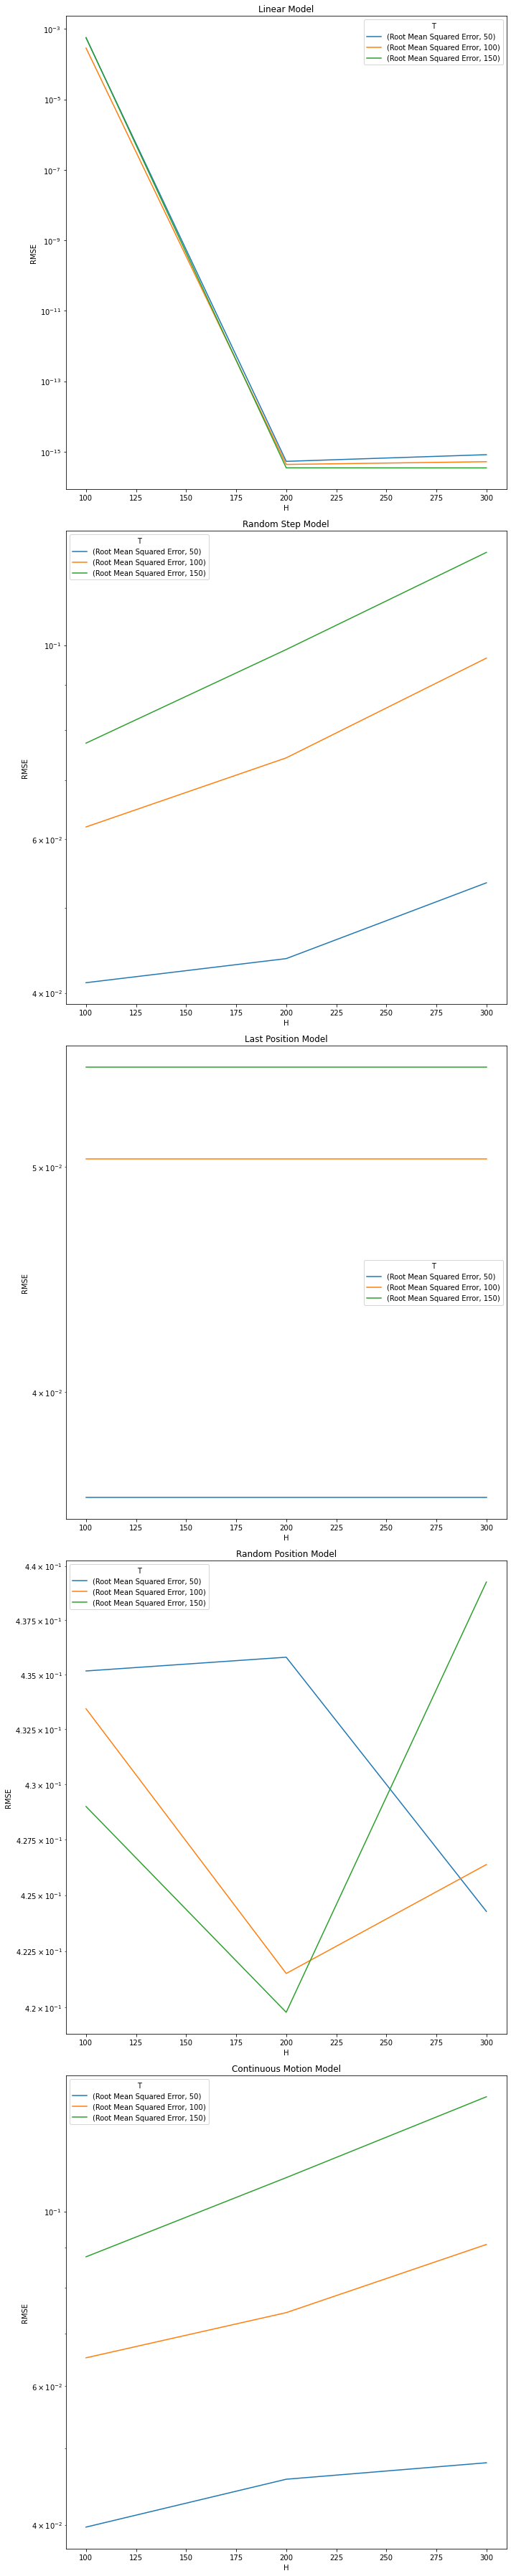

In [175]:
LOG_PLOT = True

# Plot the results table, one table per model
subplot_amount = len(model_getters)
# If just a single value combination per model, plot them all in a bar chart
if len(H_values) == 1 and len(T_values) == 1:
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    results_table.unstack().plot(ax=ax, kind='bar', logy=LOG_PLOT)
    ax.set_xlabel('H')
    ax.set_ylabel('RMSE')
    ax.legend(title='T')
else:
    # If just one T value, plot all models in the same plot
    if len(T_values) == 1:
        # The X-axis is currently tuple, take the first value only to have a single value
        results_table.xs(T_values[0], level='T').unstack().plot(
            kind='line', logy=LOG_PLOT)

        plt.xlabel('H')
        plt.ylabel('RMSE')
        plt.legend(title='T')
    elif len(H_values) == 1:
        # If just one H value, plot all models in the same plot
        results_table.xs(H_values[0], level='H').unstack().plot(
            kind='line', logy=LOG_PLOT)

        plt.xlabel('T')
        plt.ylabel('RMSE')
        plt.legend(title=f'H={H_values[0]}')
    else:
        fig, axs = plt.subplots(
            subplot_amount, 1, figsize=(10, 10*subplot_amount))
        for i, model_name in enumerate(model_getters.keys()):
            # Plot the results for the model, H on the x-axis, RMSE on the y-axis, and different lines for different T
            results_table.xs(model_name, level='Model').unstack().plot(
                ax=axs[i] if subplot_amount > 1 else axs, title=model_name, logy=LOG_PLOT)
            (axs[i] if subplot_amount > 1 else axs).set_xlabel('H')
            (axs[i] if subplot_amount > 1 else axs).set_ylabel('RMSE')
            (axs[i] if subplot_amount > 1 else axs).legend(title='T')

plt.tight_layout()

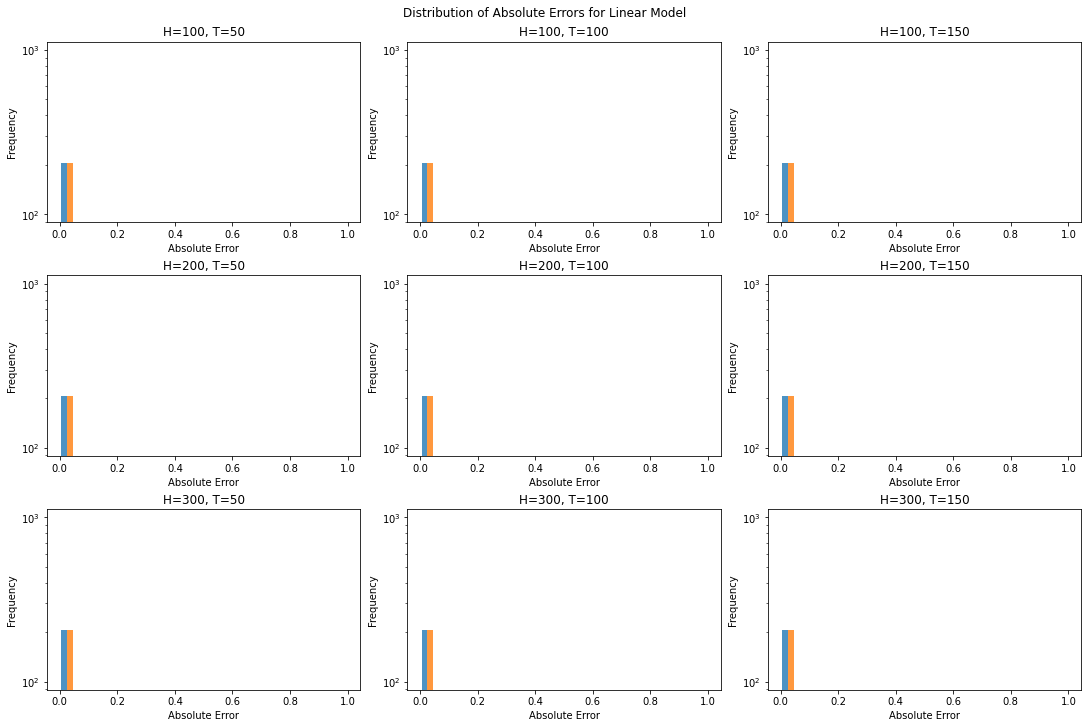

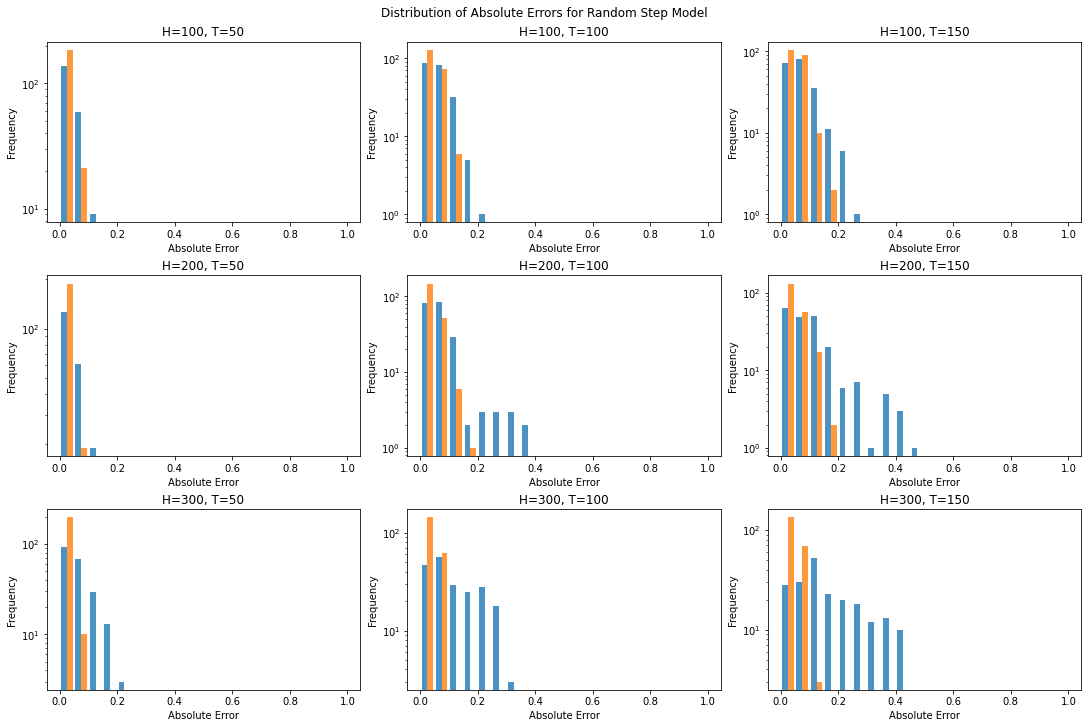

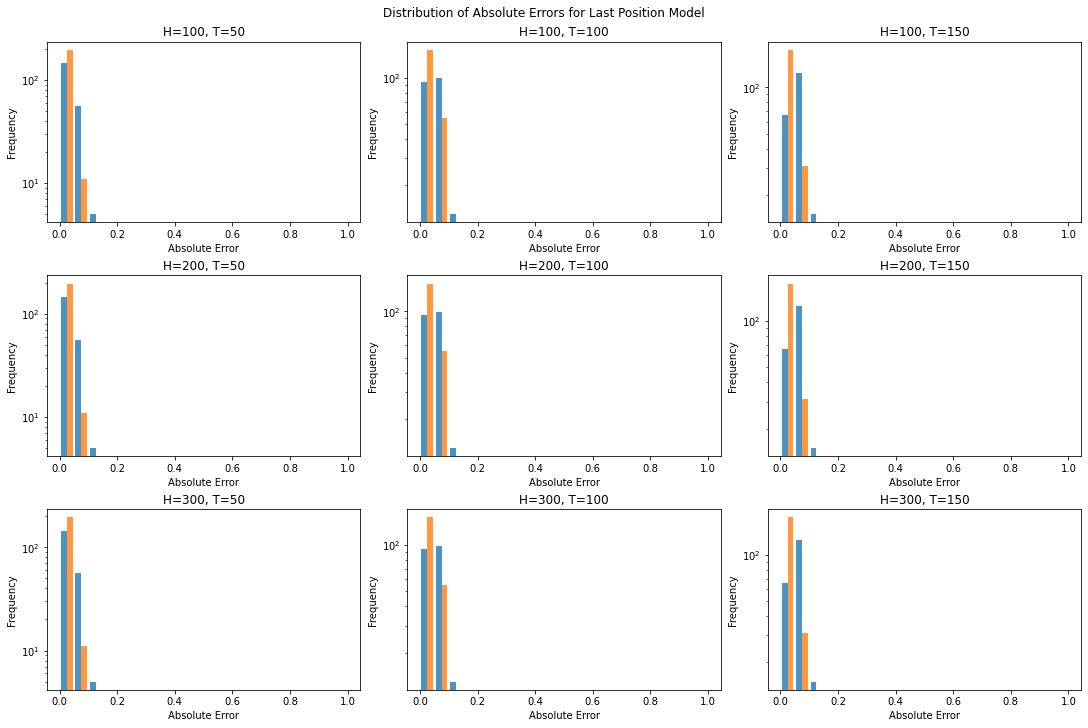

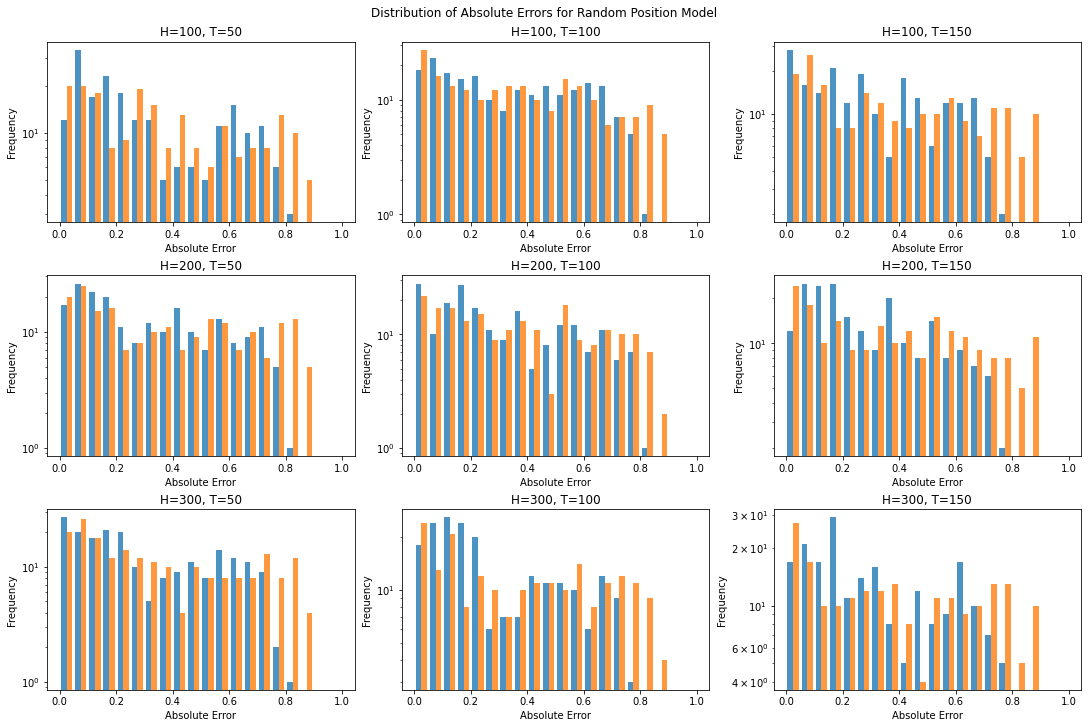

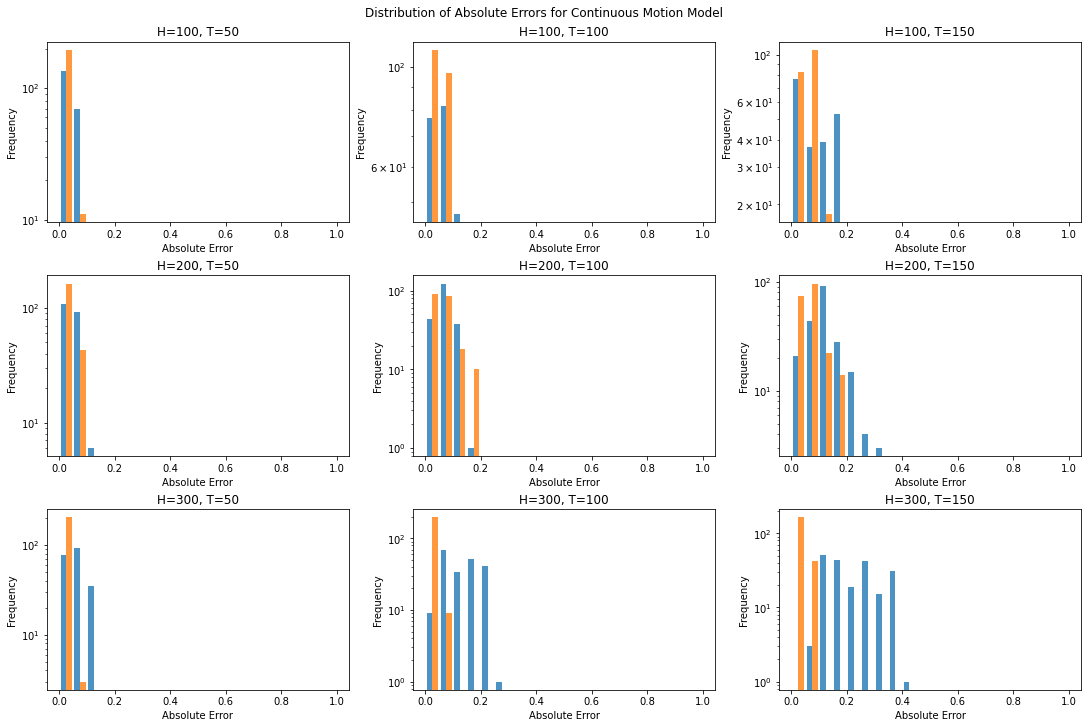

In [176]:
# Plot the distribution of absolute errors for each model
if len(H_values) == 1 and len(T_values) == 1:
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    for (H, T, name), errors in absolute_errors.items():
        errors = errors.flatten()
        ax.hist(errors, bins=100, alpha=0.5,
                label=f'H={H}, T={T}', range=(0, 1), log=LOG_PLOT)
    ax.set_xlabel('Absolute Error')
    ax.set_ylabel('Frequency')
    ax.legend()
elif len(T_values) == 1:
    fig, axs = plt.subplots(
        len(H_values), 1, figsize=(10, 10*len(H_values)))
    for i, model_name in enumerate(model_getters.keys()):
        for (H, T, name), errors in [item for item in absolute_errors.items() if item[0][2] == model_name]:
            errors = errors.flatten()
            axs[i].hist(errors, bins=100, alpha=0.5,
                        label=f'{name} H={H}', range=(0, 1), log=LOG_PLOT)
        axs[i].set_title(f'{model_name}')
        axs[i].set_xlabel('Absolute Error')
        axs[i].set_ylabel('Frequency')
        axs[i].legend()
elif len(H_values) == 1:
    fig, axs = plt.subplots(
        len(T_values), 1, figsize=(10, 10*len(T_values)))
    for i, model_name in enumerate(model_getters.keys()):
        for (H, T, name), errors in [item for item in absolute_errors.items() if item[0][2] == model_name]:
            errors = errors.flatten()
            axs[i].hist(errors, bins=100, alpha=0.5,
                        label=f'{name} T={T}', range=(0, 1), log=LOG_PLOT)
        axs[i].set_title(f'{model_name}')
        axs[i].set_xlabel('Absolute Error')
        axs[i].set_ylabel('Frequency')
        axs[i].legend()
else:
    for i, model_name in enumerate(model_getters.keys()):
        # Determine the number of rows and columns for the subplots
        num_rows = len(H_values)
        num_cols = len(T_values)

        # Create a figure and a grid of subplots
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(
            15, 10), constrained_layout=True)

        for i, H in enumerate(H_values):
            for j, T in enumerate(T_values):
                ax = axs[i, j]
                errors = absolute_errors[(H, T, model_name)]
                ax.hist(errors, bins=20, alpha=0.8, range=(0, 1), log=LOG_PLOT)
                ax.set_title(f'H={H}, T={T}')
                ax.set_xlabel('Absolute Error')
                ax.set_ylabel('Frequency')

        plt.suptitle('Distribution of Absolute Errors for ' + model_name)
        plt.show()

In [89]:
# Animate first 5 predictions for each model

def create_prediction_animation_for_models(trained_models, data, map_image_path, zoom_range, options={}):
    """
    Create an animation of the player positions and future predictions on the map for each model.

    Args:
    trained_models (dict): A dictionary of trained models
    H (int): The length of the input sequence
    T (int): The length of the target sequence
    data (dict): A dictionary of games
    map_image_path (str): The path to the map image
    zoom_range (tuple): The x and y limits to zoom in to
    options (dict): Additional options for the plot:
        - figsize (tuple): The size of the plot
        - title (str): The title of the plot
        - inputPointsSize (int[]): Array of sizes for the input points
        - predictionPointsSize (int[]): Array of sizes for the prediction points
        - truthPointsSize (int[]): Array of sizes for the truth points
        - inputPointsColor (str[]): Array of colors for the input points
        - predictionPointsColor (str[]): Array of colors for the prediction points
        - truthPointsColor (str[]): Array of colors for the truth points
        - padding (int): The padding to add to the zoom range
        - speed (int): The speed of the animation
    """
    for i, (model_name, model) in enumerate(trained_models.items()):
        H, T, _ = model_name
        X_train, X_test, y_train, y_test, _, _ = sequence_data[(H, T)]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        options['title'] = model_name
        create_prediction_animation(
            X_test, y_pred, y_test, map_image_path, zoom_range, options)
    plt.tight_layout()


# create_prediction_animation_for_models(
#     trained_models, data, map_image_path, zoom_range, options)

In [90]:
# Save models to disk

for (H, T, model_name), model in trained_models.items():
    joblib.dump(
        model, f'models/{model_name.replace(" ", "_")}_H_{H}_T_{T}.joblib')

In [91]:
# Load models from disk - get models and load them into the trained_models dictionary

# Get all H and T values from the file names
import os
import re

loaded_models = {}

model_files = os.listdir('models')
model_files = [file for file in model_files if file.endswith('.joblib')]
pattern = re.compile(r'(\w+)_(\d+)_(\d+).joblib')
for file in model_files:
    match = pattern.match(file)
    if match:
        model_name, H, T = match.groups()
        H = int(H)
        T = int(T)
        model = joblib.load(f'models/{file}')
        loaded_models[(H, T, model_name)] = model

In [92]:
# Create a small example prediction animation for each model
# example_data = data[:5]

# trained_models = {key: trained_models[key]
#                   for key in list(trained_models.keys())[:4]}
# create_prediction_animation_for_models(
#     trained_models, example_data, map_image_path, zoom_range, options)